In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as ts
from keras.preprocessing.image import load_img
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [ ]:
BASE_DIR='/kaggle/input/utkface-new/UTKFace'

In [ ]:
import os
from tqdm.notebook import tqdm

BASE_DIR = '/kaggle/input/utkface-new/UTKFace'

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    if filename.endswith('.jpg'):  
        image_path = os.path.join(BASE_DIR, filename) 
        
        try:
            temp = filename.split('_')
            age = int(temp[0])
            gender = int(temp[1])

            # Append to lists
            image_paths.append(image_path)
            age_labels.append(age)
            gender_labels.append(gender)
        
        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")


In [4]:
#CONVERT TO DATAFRAME

import pandas as pd

df = pd.DataFrame({
    'image': image_paths,
    'age': age_labels,
    'gender': gender_labels
})

df.head()


,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1


In [5]:
#Labels for gender

gender_dict = {0:'Male', 1:'Female'}

## For one image

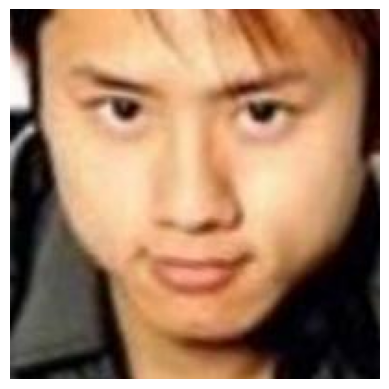

In [6]:
from PIL import Image
import matplotlib.pyplot as plt 

img = Image.open(df['image'][0])
plt.axis('off')
plt.imshow(img);

<Axes: xlabel='age', ylabel='Density'>

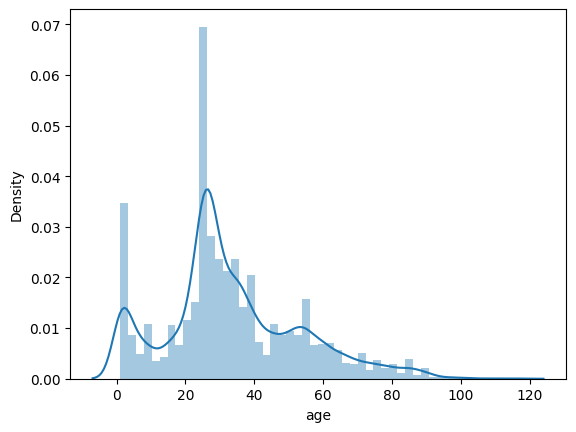

In [7]:
#It plots a histogram of the ages 

import seaborn as sns

sns.distplot(df['age'])

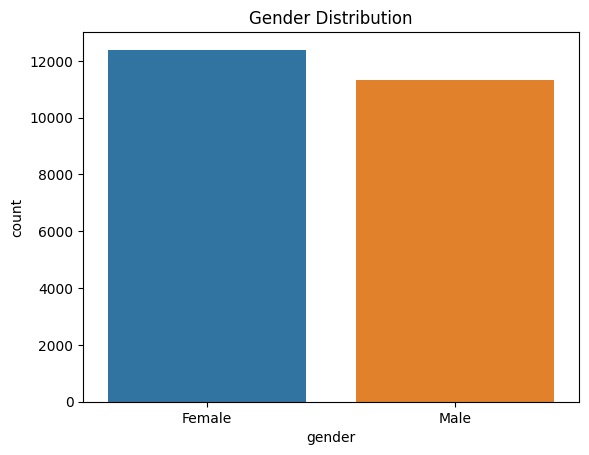

In [8]:
#this defines the gender distribution

import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='gender', data=df)

plt.xticks([0, 1], ['Female', 'Male'])
plt.title('Gender Distribution')
plt.show()

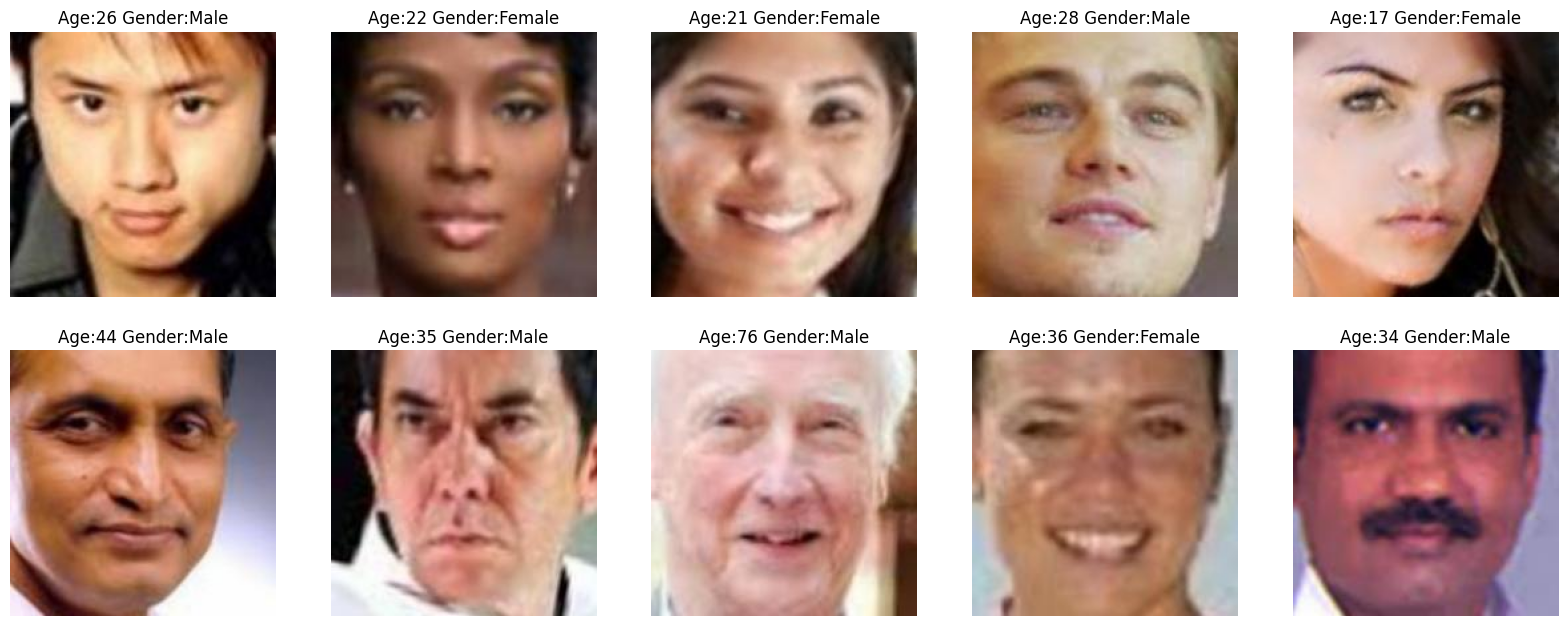

In [9]:
# To display some images eg.5 images

from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

gender_dict = {0: 'Male', 1: 'Female'}

plt.figure(figsize=(20,20))
files = df.iloc[0:10]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5,index+1)
    img = load_img(file)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')

## Features

In [33]:
# this is only for grayscale not fro RGB

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def extract_features(images):
    features = []
    for image in tqdm(images): 
        img = load_img(image, color_mode='grayscale', target_size=(128, 128))
        #img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) 
        #img = cv2.resize(img, (128, 128))
        img = img_to_array(img)
        img = img / 255.0 
        features.append(img)
    return np.array(features).reshape(-1, 128, 128, 1)

X = np.array(X).reshape(-1, 128, 128, 1)

In [34]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [35]:
print(X.shape)

(23708, 128, 128, 1)


In [36]:
# Normaliztion of images
X = X / 255.0

In [37]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [38]:
input_shape = (128,128,1)


## Model Creation

In [51]:
inputs = Input((input_shape))
# these are the conventional layers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

input_shape = (128, 128, 1)

inputs = Input(shape=input_shape) 

conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2)) (conv_1)

conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2)) (conv_2)

conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2)) (conv_3)

conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2)) (conv_4)

conv_5 = Conv2D(512, kernel_size=(3,3), activation='relu')(maxp_4)
maxp_5 = MaxPooling2D(pool_size=(2,2))(conv_5)


flatten = Flatten() (maxp_4)

#connected layers
dense_1 = Dense(256,activation='relu')(flatten)
dense_2 = Dense(256,activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_gender = Dense(1,activation='sigmoid', name='gender_out')(dropout_1)
output_age = Dense(1,activation='linear', name='age_out')(dropout_2)

model = Model(inputs=inputs, outputs=[output_gender, output_age])

model.compile(loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
              optimizer='adam',
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 126, 126,  │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 63, 63,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 30, 30,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 14, 14,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_22… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 6, 6, 256) │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=1e-4)

model.compile(optimizer=optimizer,
              loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
              metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)


In [54]:
history = model.fit(x=X,y=[y_gender,y_age],batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - age_out_loss: 19.5848 - age_out_mae: 19.5848 - gender_out_accuracy: 0.5113 - gender_out_loss: 0.6946 - loss: 20.2794 - val_age_out_loss: 15.1994 - val_age_out_mae: 15.1619 - val_gender_out_accuracy: 0.5299 - val_gender_out_loss: 0.6931 - val_loss: 15.8550
Epoch 2/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_loss: 15.0541 - age_out_mae: 15.0541 - gender_out_accuracy: 0.5185 - gender_out_loss: 0.6931 - loss: 15.7471 - val_age_out_loss: 15.1525 - val_age_out_mae: 15.1140 - val_gender_out_accuracy: 0.5299 - val_gender_out_loss: 0.6927 - val_loss: 15.8067
Epoch 3/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_out_loss: 15.1131 - age_out_mae: 15.1131 - gender_out_accuracy: 0.5208 - gender_out_loss: 0.6928 - loss: 15.8059 - val_age_out_loss: 15.2009 - val_age_out_mae: 15.1640 - val_gender_out_accuracy: 0.5299 - val_gender_out_loss: 0.6925 - val_loss: 15.8565
Epoch 4/100
593/593 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - age_

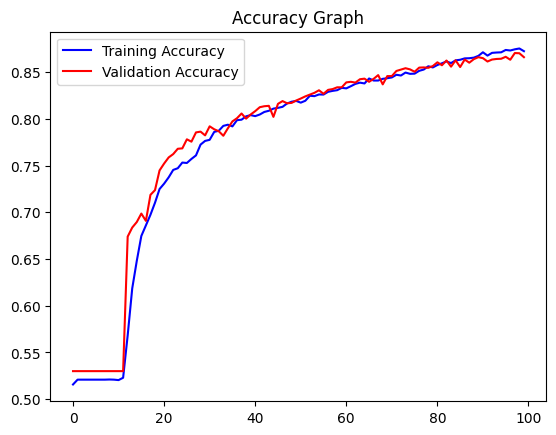

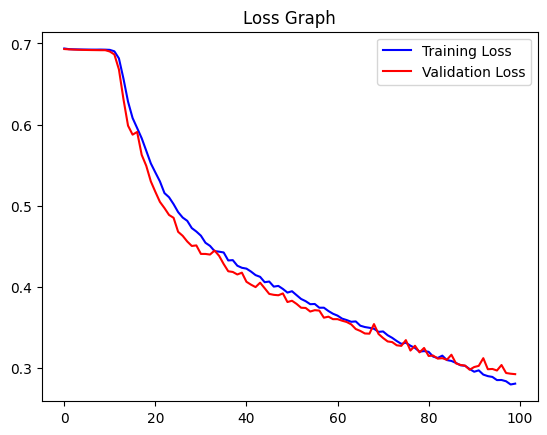

In [55]:
#Results for the gennder
acc = history.history['gender_out_accuracy']
val_acc =  history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b',label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss =  history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b',label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


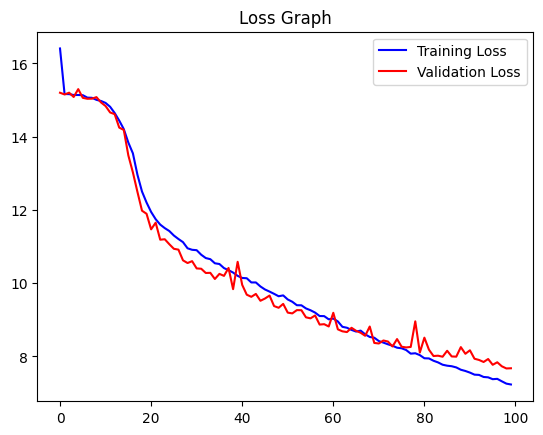

In [56]:
#Results for the age 
loss = history.history['age_out_loss']
val_loss =  history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b',label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()


## Testing

Original Gender: Female Original Age: 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step
Predicted Gender: Male Predicted Age: 4


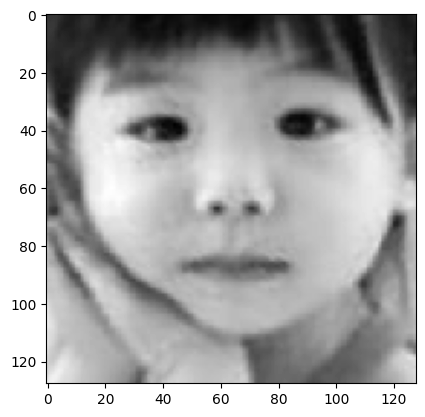

In [57]:
image_index = 100
print("Original Gender:",gender_dict[y_gender[image_index]],"Original Age:",y_age[image_index])
#now predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1)) 
pred_gender =gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()

Original Gender: Male Original Age: 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted Gender: Male Predicted Age: 47


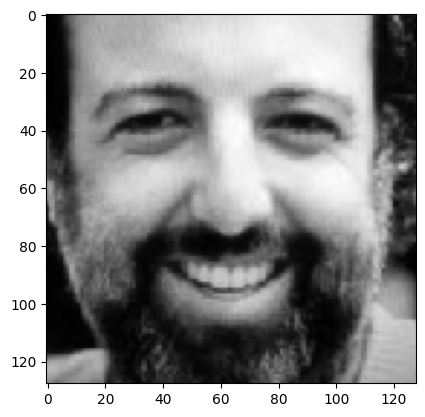

In [59]:
image_index =10000
print("Original Gender:",gender_dict[y_gender[image_index]],"Original Age:",y_age[image_index])
#now predict from the model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1)) 
pred_gender =gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:",pred_age)
plt.imshow(X[image_index].reshape(128, 128), cmap='gray')
plt.show()